# Project

...

## Details

...

## Implementation

...

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import roc_curve, auc
plt.rcParams['figure.figsize'] = (8.0,5.0)
plt.rcParams['font.size'] = 14

In [3]:
def i_m_test(x_i_j):
    T_i = stats.rankdata(x_i_j, axis=0)-1
    T_v = np.sum(T_i, axis=1)
    
    N = x_i_j.shape[1]
    k = T_i.shape[0]
    
    mu = N*(k-1) / 2
    var = N*(k**2 -1) / 12
    
    T = np.sum((T_v - mu)**2 / var)
    
    return stats.chi2(df=k-1).sf(T)

## Comparison (Kruskal-Wallis)

...

In [4]:
def kruskal_wallis(x_i_j):
    n_i = np.array([len(xi_j) for xi_j in x_i_j])
    k = len(n_i)
    N = np.sum(n_i)
    
    x_r = np.concatenate(x_i_j)
    R_r = stats.rankdata(x_r)
    i_r = np.concatenate([(i,)*n_i[i] for i in range(k)])
    R_i_j = [R_r[i_r==i] for i in range(k)]
    R_i = np.array([np.sum(Ri_j) for Ri_j in R_i_j])
    
    Rbar = 0.5*(N+1)
    T = (N-1) * np.sum((R_i-n_i*Rbar)**2/n_i) / np.sum((R_r-Rbar)**2)
    
    p = stats.chi2(df=k-1).sf(T)
    
    return p

## Example Comparison

...

In [5]:
x_i_j = np.array([
    np.array([ 14.97,   5.80,  25.03,   5.50 ]),
    np.array([  5.83,  13.96,  21.96,   55.51 ]),
    np.array([ 17.89,  23.03,  61.09,   18.62 ])
])

In [6]:
kruskal_wallis(x_i_j)

0.2920678236914142

In [7]:
i_m_test(x_i_j)

0.07243975703425146

## Experiments

...

In [8]:
def run_experiment(
    effect_size, x_i_j_k, title,
    n_trials=1000, alpha=0.05
):
    ks_power = []
    im_power = []

    all_ks_pvals_null = []
    all_im_pvals_null = []
    all_ks_pvals_alt = []
    all_im_pvals_alt = []

    for e in effect_size:
        ks_rejects = 0
        im_rejects = 0

        ks_pvals_null = []
        im_pvals_null = []
        ks_pvals_alt = []
        im_pvals_alt = []

        for _ in range(n_trials):
            # --- null hypothesis (no effect)
            x_1_null = stats.norm(0, 1).rvs(10)
            x_2_null = stats.norm(0, 1).rvs(10)
            x_3_null = stats.norm(0, 1).rvs(10)
            x_null = np.array([x_1_null, x_2_null, x_3_null])

            ks_pvals_null.append(kruskal_wallis(x_null))
            im_pvals_null.append(i_m_test(x_null))

            # --- alternative hypothesis (with effect)
            x_1_alt = stats.norm(e, 1).rvs(10)
            x_2_alt = stats.norm(0, 1).rvs(10)
            x_3_alt = stats.norm(0, 1).rvs(10)
            x_alt = np.array([x_1_alt, x_2_alt, x_3_alt])

            ks_p = kruskal_wallis(x_alt)
            im_p = i_m_test(x_alt)

            ks_pvals_alt.append(ks_p)
            im_pvals_alt.append(im_p)

            if ks_p < alpha:
                ks_rejects += 1
            if im_p < alpha:
                im_rejects += 1

        ks_power.append(ks_rejects / n_trials)
        im_power.append(im_rejects / n_trials)

        all_ks_pvals_null.extend(ks_pvals_null)
        all_im_pvals_null.extend(im_pvals_null)
        all_ks_pvals_alt.extend(ks_pvals_alt)
        all_im_pvals_alt.extend(im_pvals_alt)

    # --- power Curve
    plt.figure(figsize=(8, 4))
    plt.plot(effect_size, ks_power, label='Kruskal-Wallis')
    plt.plot(effect_size, im_power, label='IM Test')
    plt.xlabel("Effect Size")
    plt.ylabel("Power")
    plt.title(f'{title} | Power Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- ROC curve (using final effect_size only for alt)
    labels = np.array([0]*len(all_ks_pvals_null) + [1]*len(all_ks_pvals_alt))

    # kruskal ROC
    scores_ks = 1 - np.array(all_ks_pvals_null + all_ks_pvals_alt)
    fpr_ks, tpr_ks, _ = roc_curve(labels, scores_ks)
    auc_ks = auc(fpr_ks, tpr_ks)

    # IM ROC
    scores_im = 1 - np.array(all_im_pvals_null + all_im_pvals_alt)
    fpr_im, tpr_im, _ = roc_curve(labels, scores_im)
    auc_im = auc(fpr_im, tpr_im)

    plt.figure(figsize=(8, 5))
    plt.plot(fpr_ks, tpr_ks, label=f"Kruskal-Wallis (AUC = {auc_ks:.2f})")
    plt.plot(fpr_im, tpr_im, label=f"IM Test (AUC = {auc_im:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f'{title} | ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

### 01 | Normal vs. Normal 

...

#### N=100

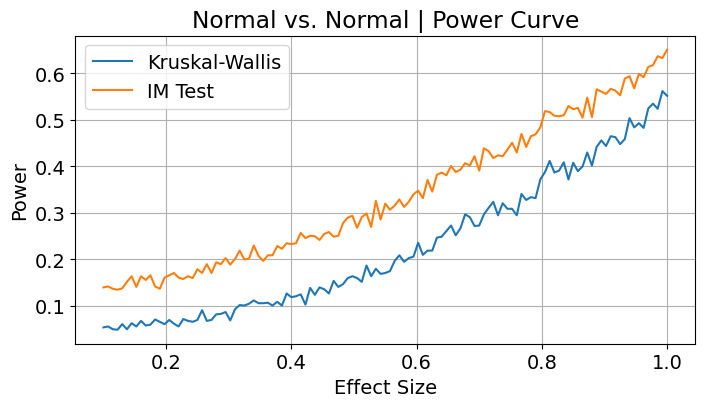

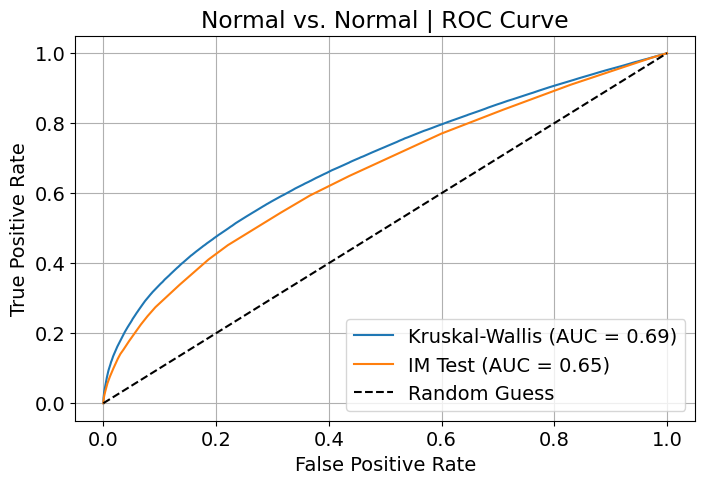

In [9]:
effect_size = np.linspace(0.1, 1, 121)
n=100

x_1 = np.array([stats.norm(e, 1).rvs(n) for e in effect_size])
x_2 = stats.norm(0, 1).rvs(effect_size.shape+(n,))
x_3 = stats.norm(0, 1).rvs(effect_size.shape+(n,))

x_i_j_k = np.array([x_1, x_2, x_3])

run_experiment(effect_size, x_i_j_k, 'Normal vs. Normal')

#### N=10

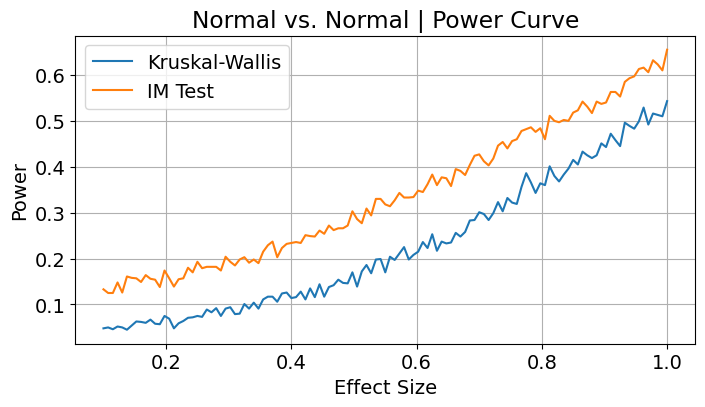

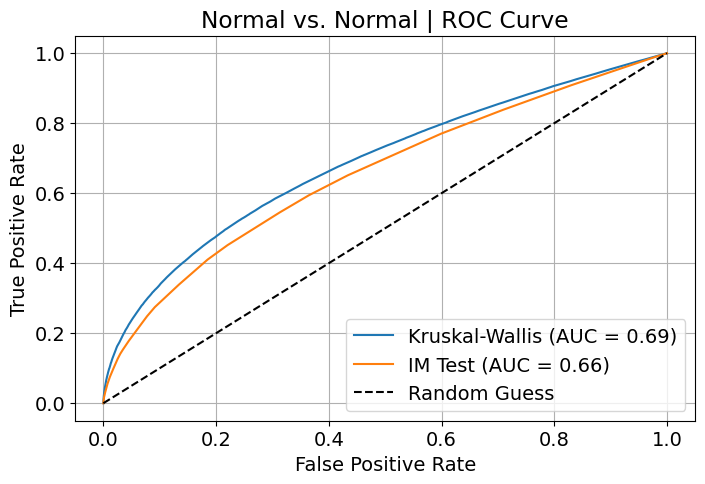

In [10]:
effect_size = np.linspace(0.1, 1, 121)
n=10

x_1 = np.array([stats.norm(e, 1).rvs(n) for e in effect_size])
x_2 = stats.norm(0, 1).rvs(effect_size.shape+(n,))
x_3 = stats.norm(0, 1).rvs(effect_size.shape+(n,))

x_i_j_k = np.array([x_1, x_2, x_3])

run_experiment(effect_size, x_i_j_k, 'Normal vs. Normal')

#### N=4

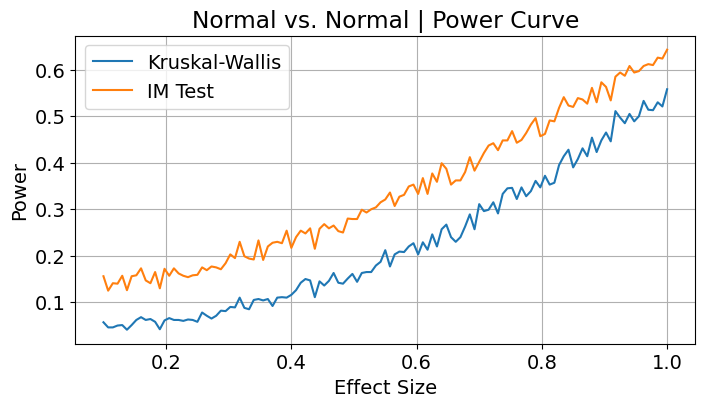

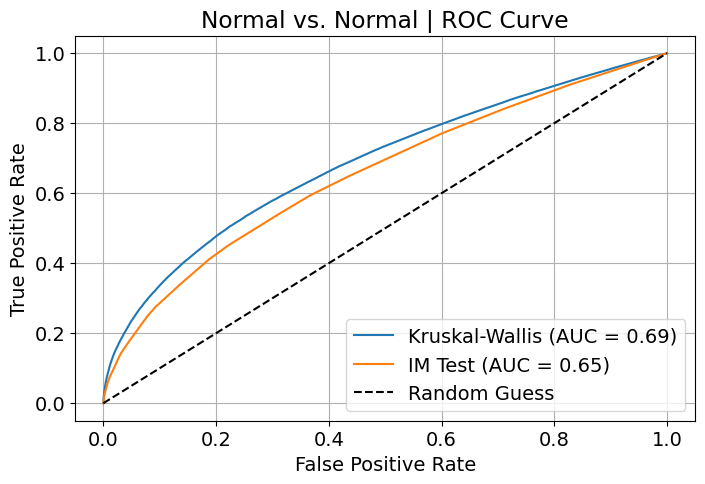

In [11]:
effect_size = np.linspace(0.1, 1, 121)
n=4

x_1 = np.array([stats.norm(e, 1).rvs(n) for e in effect_size])
x_2 = stats.norm(0, 1).rvs(effect_size.shape+(n,))
x_3 = stats.norm(0, 1).rvs(effect_size.shape+(n,))

x_i_j_k = np.array([x_1, x_2, x_3])

run_experiment(effect_size, x_i_j_k, 'Normal vs. Normal')

#### $\mu_N$=2, L=121

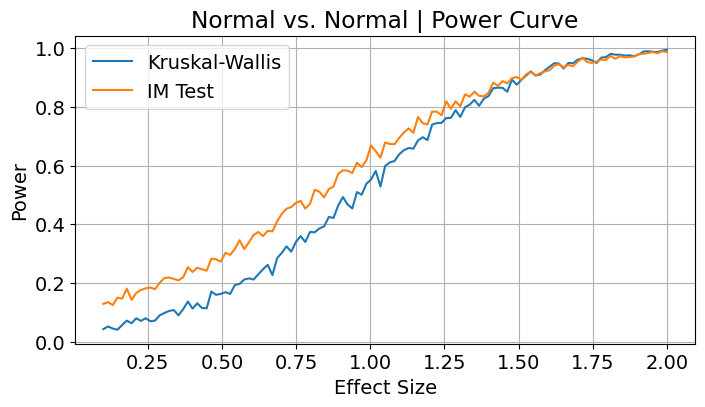

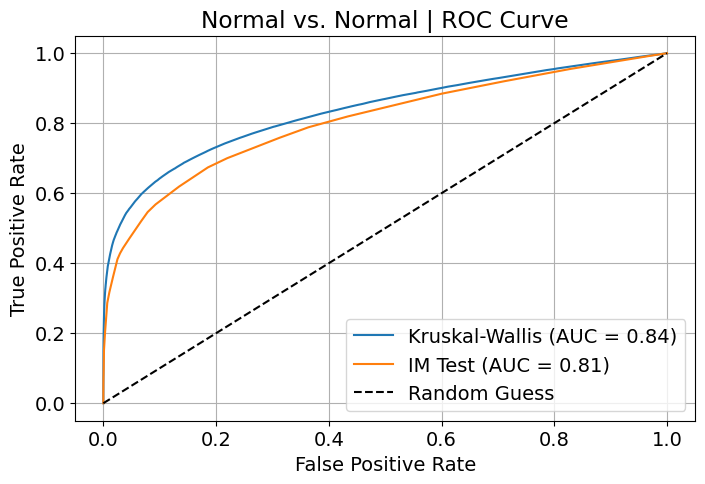

In [12]:
effect_size = np.linspace(0.1, 2.0, 121)
n=100

x_1 = np.array([stats.norm(e, 1).rvs(n) for e in effect_size])
x_2 = stats.norm(0, 1).rvs(effect_size.shape+(n,))
x_3 = stats.norm(0, 1).rvs(effect_size.shape+(n,))

x_i_j_k = np.array([x_1, x_2, x_3])

run_experiment(effect_size, x_i_j_k, 'Normal vs. Normal')

#### $\mu_N$=2, L=300

In [ ]:
effect_size = np.linspace(0.1, 2.0, 300)
n=100

x_1 = np.array([stats.norm(e, 1).rvs(n) for e in effect_size])
x_2 = stats.norm(0, 1).rvs(effect_size.shape+(n,))
x_3 = stats.norm(0, 1).rvs(effect_size.shape+(n,))

x_i_j_k = np.array([x_1, x_2, x_3])

run_experiment(effect_size, x_i_j_k, 'Normal vs. Normal')

#### $\mu_N$=5, L=1000

In [ ]:
effect_size = np.linspace(0.1, 5.0, 1000)
n=100

x_1 = np.array([stats.norm(e, 1).rvs(n) for e in effect_size])
x_2 = stats.norm(0, 1).rvs(effect_size.shape+(n,))
x_3 = stats.norm(0, 1).rvs(effect_size.shape+(n,))

x_i_j_k = np.array([x_1, x_2, x_3])

run_experiment(effect_size, x_i_j_k, 'Normal vs. Normal')